In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

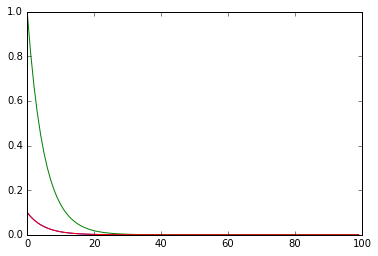

In [2]:
spikes = 1. * (np.random.rand(10000, 2) > 0.9)
kernel = np.exp(-np.arange(100)/5.)[:,None] * np.array([0.1, 1., 0.1])[None, :]
plt.plot(kernel)

In [3]:
from scipy import signal
lfp = signal.fftconvolve(spikes, kernel, 'same').T
mixture_matrix = np.array([[1., 0.5], [0.5, 1]])
lfp += np.random.randn(*lfp.shape) 

lfp = np.dot(mixture_matrix, lfp)
np.corrcoef(lfp)

array([[ 1.       ,  0.8116517],
       [ 0.8116517,  1.       ]])

In [4]:
from scipy import stats
cov_mat = np.cov(lfp)

In [5]:
def whitening_matrix(cov, cutoff=0.01):
    evals, evecs = np.linalg.eig(cov)

    inv_evals = 1./np.sqrt(evals)
    inv_evals[evals<cutoff*evals.max()] = 0

    w_mat = np.dot(np.dot(evecs, np.diag(inv_evals)), evecs.T)
    
    return w_mat


In [6]:
W = whitening_matrix(cov_mat)
W_opt = np.linalg.inv(mixture_matrix)

In [7]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')

In [8]:

def plot_sta(spike_triggered):
    def _normalise(x):
        return (x-x.min(0))/x.max()
    N = spike_triggered.shape[1]
    sta = spike_triggered[:, N/2-49:N/2-20].T
    plt.plot(_normalise(sta), lw=2)

    plt.twinx()
    K = kernel[:30, 1:]
    plt.plot(_normalise(K))
    plt.xlim(-10, 50)


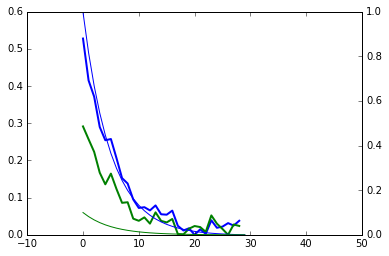

In [9]:
plot_sta(spike_triggered)

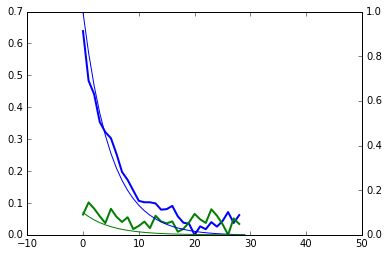

In [10]:

whitened_stlfp = np.dot(W, spike_triggered)

plot_sta(whitened_stlfp)

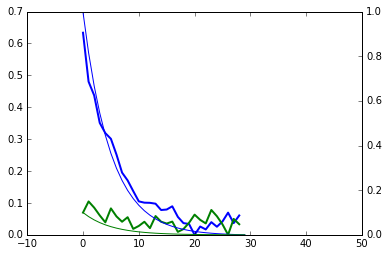

In [11]:

whitened_stlfp = np.dot(W_opt, spike_triggered)

plot_sta(whitened_stlfp)

In [12]:
print W

[[ 1.18171219 -0.60850514]
 [-0.60850514  1.19363576]]


In [13]:
print np.linalg.inv(mixture_matrix)

[[ 1.33333333 -0.66666667]
 [-0.66666667  1.33333333]]


## Co-modulated Poisson population

In [14]:
npts = 1000000
N = 100
mixture_matrix = np.array([[0.51, 0.49], [0.49, 0.51]])
#mixture_matrix = np.ones((2, 2))
rate = np.dot(mixture_matrix,  np.random.rand(2, npts)).T
spikes = 1. * (rate > 0.6)
population = np.random.poisson(N * rate)
print np.corrcoef(spikes.T)
print np.corrcoef(population.T)
print np.corrcoef(spikes[:, 0], population[:, 0])

[[ 1.          0.97081667]
 [ 0.97081667  1.        ]]
[[ 1.          0.89196482]
 [ 0.89196482  1.        ]]
[[ 1.          0.74060702]
 [ 0.74060702  1.        ]]


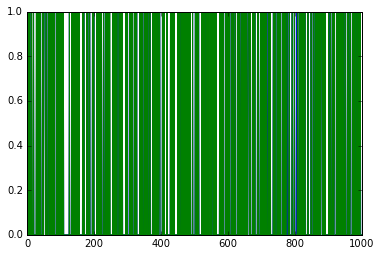

In [15]:
plt.plot(spikes[:1000, :])

In [16]:
spikes.sum(0)

array([ 319465.,  319434.])

In [17]:
kernel = np.exp(-np.arange(100)/10.)[:,None] * np.array([0.1, 1., 0.1])[None, :]

In [18]:
print kernel.shape

(100, 3)


LFP is modelled as a sum of pre-synaptic and post-synaptic contributions:

In [19]:

lfp = signal.fftconvolve(spikes, kernel, 'same').T + population.T
#lfp += N * (rate.T - rate.mean())

In [20]:
cov_mat = np.cov(lfp)
print cov_mat
W = whitening_matrix(cov_mat, 0.01)

[[ 467.71986635  417.34785077]
 [ 417.34785077  467.76950824]]


In [21]:
W

array([[ 0.08724136, -0.05362529],
       [-0.05362529,  0.08723498]])

In [22]:

spikes.sum(0)

array([ 319465.,  319434.])

In [23]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')
#spike_triggered /= signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')
whitened_stlfp = np.dot(W, spike_triggered)
#whitened_stlfp = np.dot(np.linalg.inv(mixture_matrix), spike_triggered)


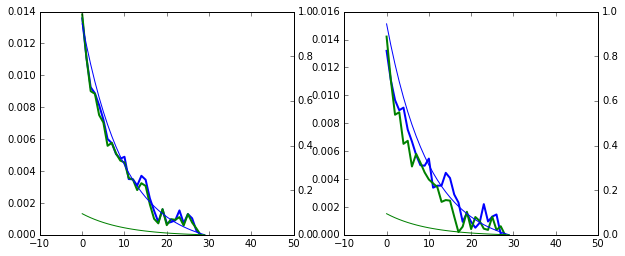

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_sta(spike_triggered)
plt.subplot(122)
plot_sta(whitened_stlfp)

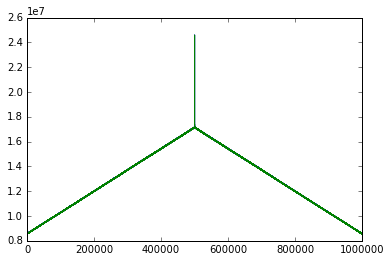

In [25]:

plt.plot(spike_triggered.T)

In [26]:
np.corrcoef(np.dot(W, lfp))

array([[  1.00000000e+00,  -2.14229027e-15],
       [ -2.14229027e-15,   1.00000000e+00]])

In [27]:
signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')

array([[ 159812.,  159813.,  159813., ...,  159653.,  159653.,  159653.],
       [ 159812.,  159813.,  159813., ...,  159653.,  159653.,  159653.]])

In [28]:
spikes.shape[0]

1000000